In [281]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.stats import iqr

TODO: Automate threshold selection for straight line detection (check if related to average brightness or contrast)

For now algo seems to work best for rectangular images (not irregularly shaped) with lines aligned mostly E-W or N-S

In [282]:
# thresh = 100

# Good labels
# ------------------------------------------
# img_id = '18_nir_2015-08-14';  thresh = 80  # nice spacing distro
img_id = '20_nir_2009-07-23'; thresh = 90  # good for demo
# img_id = '24_nir_2012-07-11'; thresh = 80  #
# img_id = '45_nir_2015-08-14'; thresh = 110 # really good lines
# img_id = '46_nir_2014-07-10';  thresh = 100  # horizontal
# img_id = '73_nir_2013-08-11';  thresh = 120 # nice lines (not so nice segments)
# img_id = '81_nir_2016-08-03';  thresh = 80
# img_id = '93_nir_2015-07-24'; thresh = 90
# img_id = '76_nir_2013-08-11'; thresh = 80
# img_id = '0_nir_2016-09-03'; thresh = 60
# img_id = '8_nir_2016-08-09'; thresh = 80
# img_id = '15_nir_2010-08-14'; thresh = 70
# img_id = '19_nir_2013-07-28'; thresh = 80
# img_id = '35_nir_2011-08-03'; thresh = 90  # bad for prob. hough
# img_id = '77_nir_2013-08-11'; thresh = 90 # bad for prob. hough

# Not so good labels
# ------------------------------------------
# img_id = '15_nir_2010-08-14'; thresh = 70
# img_id = '16_nir_2016-06-27'; thresh = 90 # bad for prob. hough
# img_id = '1_nir_2010-07-26'; thresh = 50
# img_id = '3_nir_2013-08-01'; thresh = 60
# img_id = '23_nir_2015-08-14'; thresh = 80
# img_id = '48_nir_2011-06-27'; thresh = 80
# img_id = '74_nir_2013-08-11'; thresh = 60
# img_id = '55_nir_2010-08-25';  thresh = 90 # irregular shape, 2 patterns

# Bad labels
# ------------------------------------------
# img_id = '15_nir_2010-08-14';  thresh = 80 
# img_id = '27_nir_2014-07-10';  thresh = 60 # diagonal lines
# img_id = '31_nir_2012-06-19';  thresh = 90 # needs to be cropped
# img_id = '64_nir_2013-08-11';  thresh = 80# has 3 patterns
# img_id = '4_nir_2011-08-26'; thresh = 60
# img_id = '11_nir_2015-07-18'; thresh = 80
# img_id = '26_nir_2012-07-02'; thresh = 100
# img_id = '65_nir_2013-08-01'; thresh = 100
# img_id = '91_nir_2014-08-12'; thresh = 90
# img_id = '78_nir_2013-08-11'; thresh = 70 # 2 patterns

# Labels for no patterns
# ------------------------------------------
# img_id = '0_blue_2016-09-03'; thresh = 50
# img_id = '4_blue_2011-08-26'; thresh = 50

# filein = '../data/fields_nir/' + img_id + '.png'
filein = '../data/fields_raw/' + img_id + '.png'


In [283]:
def plot_lines(lines):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        plt.plot([x1,x2],[y1,y2],'y')

In [284]:
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

## Load raw image, normalize, saturate, denoise

In [285]:
# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

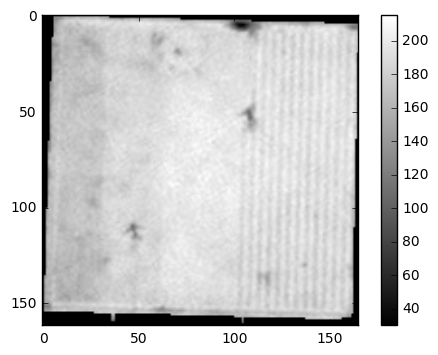

In [286]:
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

In [287]:
# Crop
length = gray_raw.shape[0]
width = gray_raw.shape[1]

frac = 0.05
x1 = int(frac*length)
x2 = length - int(frac*length)
y1 = int(frac*width)
y2 = width - int(frac*width)

cropped = gray_raw[x1:x2,y1:y2]

gray_raw = cropped

In [288]:
# For plotting, Replace min with nans
gray_nan = gray_norm.copy()
gray_nan[np.where(gray_nan==np.min(gray_nan))] = np.nan
# gray_nan[np.where(gray_nan==np.min(gray_nan))]

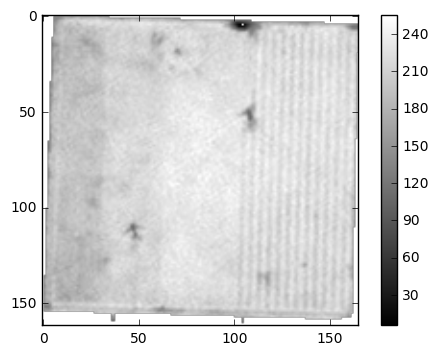

In [289]:
plt.imshow(gray_nan,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

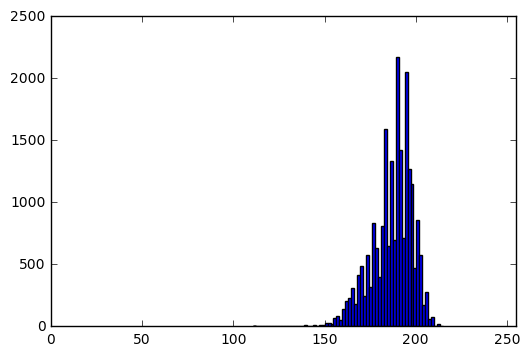

In [290]:
# Plot histogram of values excluding min values

gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)
# gray_vec = gray_vec[~np.isnan(gray_vec)]
plt.hist(gray_vec,64)
plt.xlim(0,255)
plt.show()

In [291]:
# Saturate scale based on percentiles
edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

In [292]:
b,t

(165.0, 203.0)

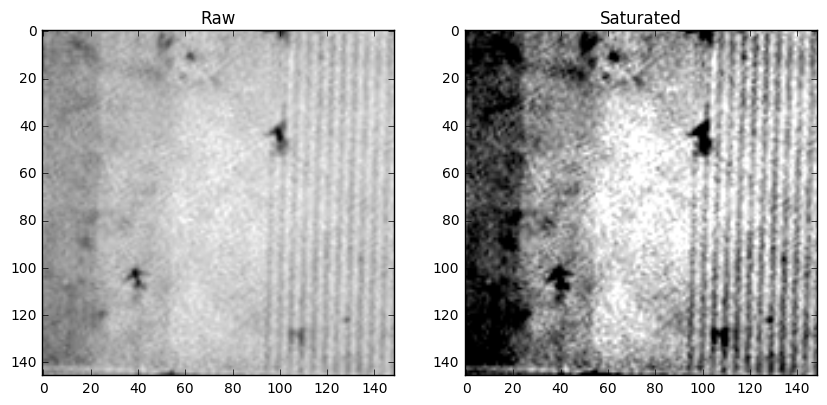

In [293]:
# Plot original and saturated images
plt.figure(figsize=(10, 20))

plt.subplot(1,2,1)
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Raw')

plt.subplot(1,2,2)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Saturated')

plt.show()

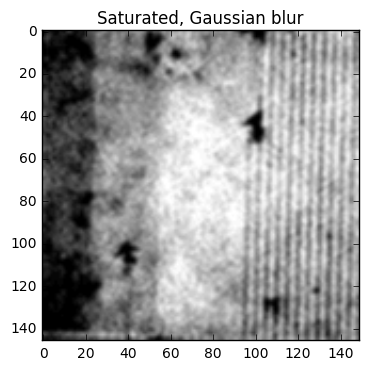

In [294]:
# Gaussian blur?
blur = cv2.GaussianBlur(gray_sat,(3,3),0)
plt.imshow(blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Saturated, Gaussian blur')
plt.show()

## Thresholding

In [295]:
# Try some thresholding

# # On raw image
# thr_val_raw = np.median(gray_raw)
# ret,thr_raw = cv2.threshold(gray_raw,thr_val_raw,255,cv2.THRESH_BINARY)

# Binary on saturated image
thr_val_sat = np.median(gray_sat)
ret,thr_sat = cv2.threshold(gray_sat,thr_val_sat,255,cv2.THRESH_BINARY)

# Binary On saturated + Gaussian blur
thr_val_blur = np.median(blur)
ret,thr_blur = cv2.threshold(blur,thr_val_blur,255,cv2.THRESH_BINARY)

# Adaptive on saturated image
thr_ad = cv2.adaptiveThreshold(gray_sat,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

# Adaptive on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)


# ret,thr = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)


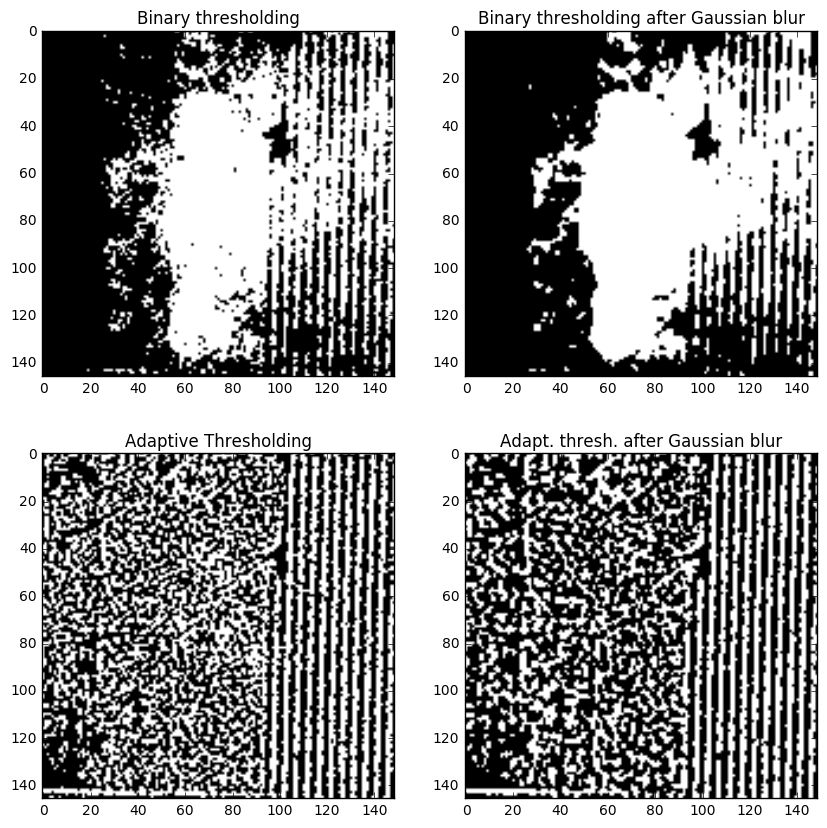

In [296]:
# Plot thresholded image
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.imshow(thr_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Binary thresholding')

plt.subplot(2,2,2)
plt.imshow(thr_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Binary thresholding after Gaussian blur')

plt.subplot(2,2,3)
plt.imshow(thr_ad,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adaptive Thresholding')

plt.subplot(2,2,4)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adapt. thresh. after Gaussian blur')

plt.show()

In [297]:
# Adaptive thresholding for different block sizes

# thr_ad_blur_1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,0)
# thr_ad_blur_2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
# thr_ad_blur_3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,7,0)
# thr_ad_blur_4 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,0)

# plt.figure(figsize=(10, 10))

# plt.subplot(2,2,1)
# plt.imshow(thr_ad_blur_1,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 3')

# plt.subplot(2,2,2)
# plt.imshow(thr_ad_blur_2,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 5')

# plt.subplot(2,2,3)
# plt.imshow(thr_ad_blur_3,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 7')

# plt.subplot(2,2,4)
# plt.imshow(thr_ad_blur_4,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 11')

# plt.show()


## Edge detection

In [298]:
# # Edge detection on binary image (adaptive threshold after Gaussian blur)

# # edges_sat = cv2.Canny(gray_sat,50,150,apertureSize = 3)
# # edges_thr = cv2.Canny(thr_sat,50,150,apertureSize = 3)

# edges_ad_thr = cv2.Canny(thr_ad_blur,100,150,apertureSize = 5)



In [299]:
# # Plot detected eges on original and saturated images
# plt.figure(figsize=(10, 20))

# # plt.subplot(1,2,1)
# # plt.imshow(edges_sat,cmap=matplotlib.cm.get_cmap('gray'))
# # plt.title('Edges on Saturated Image')

# # plt.subplot(1,2,2)
# # plt.imshow(edges_thr,cmap=matplotlib.cm.get_cmap('gray'))
# # plt.title('Edges on Thresholded Image')

# plt.subplot(1,2,1)
# plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Thresholded Image')

# plt.subplot(1,2,2)
# plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Edges on Thresholded Image')

# plt.show()

## Line detection

For ROUGH direction detection:
If dominant line direction is NS-EW, then set 2nd threshold to 0.5 to avoid picking diagonal lines

But, if the image has diagonal lines, need to increase 2nd threshold to 1

In [300]:
# Line detection on binary image itself
lines_thr = cv2.HoughLines(thr_ad_blur,0.7,1*np.pi/180,thresh)
len(lines_thr)

27

In [301]:
# Nlines = []
# thresholds = range(70,100,10)
# for threshold in thresholds:
#     lines_thr = cv2.HoughLines(thr_ad_blur,0.5,1*np.pi/180,threshold)
#     Nlines.append(len(lines_thr))
# Nlines = np.array(Nlines)
# thresholds = np.array(thresholds)

# plt.plot(thresholds,Nlines,'.-')
# plt.show()

# Line detection on edges 
# lines_edges = cv2.HoughLines(edges_ad_thr,0.5,1*np.pi/180,60)
# len(lines_edges)

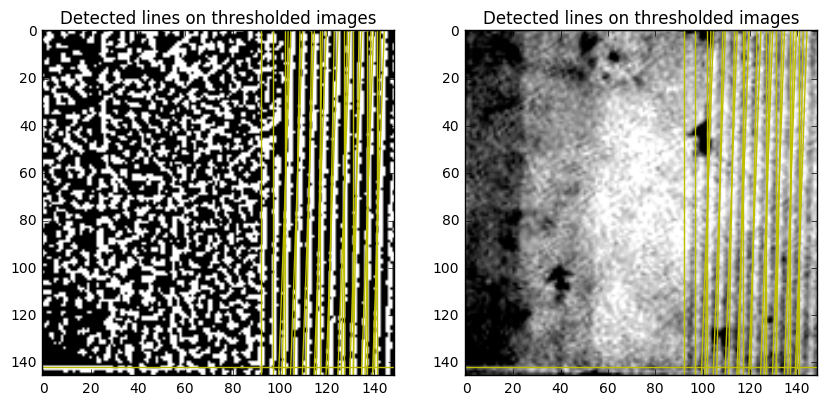

In [302]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

# plt.subplot(222)
# plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Detected lines on edges')
# ylim = plt.gca().get_ylim()
# xlim = plt.gca().get_xlim()
# plot_lines(lines_edges)
# plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(122)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

# plt.subplot(224)
# plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Detected lines on edges')
# ylim = plt.gca().get_ylim()
# xlim = plt.gca().get_xlim()
# plot_lines(lines_edges)
# plt.gca().set_ylim(ylim)
# plt.gca().set_xlim(xlim)


plt.show()


## Line segment detection

In [303]:
# Probabilistic Hough transform (detects line segments)

minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges_ad_thr,1,np.pi/180,50,minLineLength,maxLineGap)
len(lines_pr)

1700

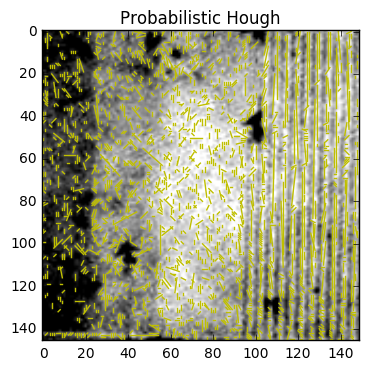

In [304]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Probabilistic Hough')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
# plot_lines(lines_pr)
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],'y')
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

In [305]:
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)


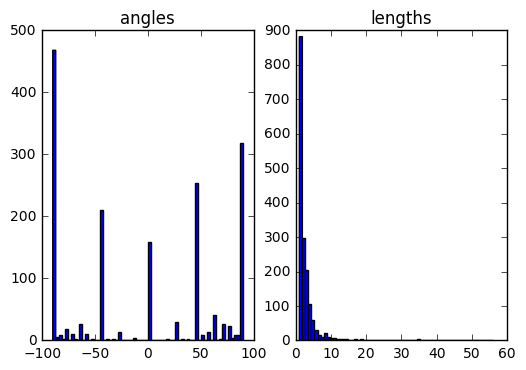

In [306]:
plt.figure
plt.subplot(121)
plt.hist(thetas_pr,64)
plt.title('angles')

plt.subplot(122)
plt.hist(lengths_pr,64)
plt.title('lengths')

plt.show()


In [307]:
# thetas_pr = 180 - thetas_pr

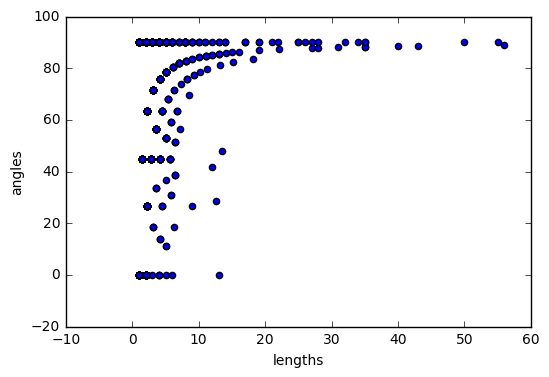

In [308]:
# This could be used to pick dominant angles given a threshold on line length

plt.scatter(lengths_pr,np.abs(thetas_pr))
plt.xlabel('lengths')
plt.ylabel('angles')
plt.show()

## Feature extraction, clustering and labeling on line segments

In [309]:
# possible feature for detecting if image contains patterns at all: 
# spread in angle in line segments with similar length
thetas_pr_rad = thetas_pr
thetas_pr = np.abs(thetas_pr)

bins = np.linspace(0, np.max(lengths_pr), 10)
digitized = np.digitize(lengths_pr, bins)

In [310]:
# feat = np.array([thetas_pr,lengths_pr]).T
feat = np.array([lengths_pr]).T

In [311]:
kmeans = KMeans(n_clusters=2).fit(feat)
labels_cl = kmeans.labels_

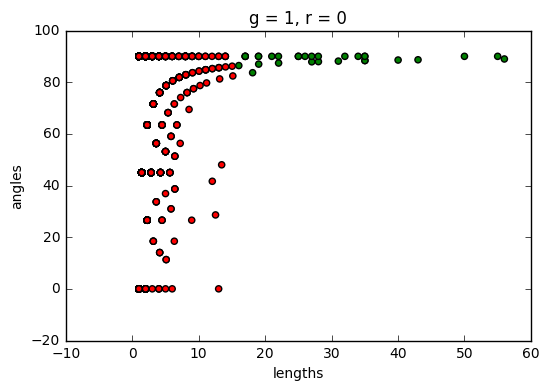

In [312]:
colors = ['g' if label else 'r' for label in labels_cl]

plt.scatter(lengths_pr,thetas_pr,c=colors)
plt.xlabel('lengths')
plt.ylabel('angles')
plt.title('g = 1, r = 0')

plt.show()

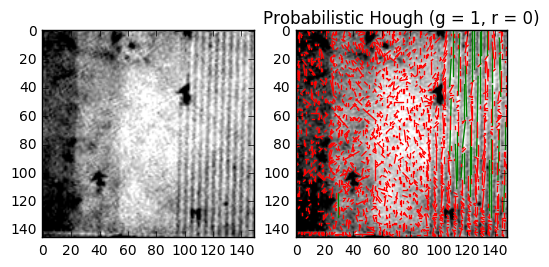

In [313]:
plt.subplot(121)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))

plt.subplot(122)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.title('Probabilistic Hough (g = 1, r = 0)')
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],c=colors[line_idx])
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

At this point, classify the images as containing patterns or not based on prediction from classifier.

Eventually I need to base this on 2 features: average length and variance in angle for each of the two clusters. If at least one of the clusters classifies positive, then classify image as containg man-made patterns.

In [ ]:
length_thresh = 6.84635 # from model

# # Compute average length of group with the *longer* lines
# avg_length = np.mean(lengths_pr)

# If average length is smaller than prediction from model, no patterns exist, stop here!
avg_length > length_thresh

# If True, continue

In [317]:
# INTERJECT HERE!

# 1. Lump into one class, assumed to be false?
lump = False

# 2. Set true class to index from k-means (0 or 1) (this doesn't matter if both classes are lamped together)
true_class = 1

# 3. Toggle switch to write to file
# write_to_file = True
write_to_file = False

In [318]:
# features for each clusters: average length, variance in angle

if lump:
    avglength_false = np.mean(lengths_pr)
    stdangle_false = np.std(thetas_pr)
    medlength_false = np.median(lengths_pr)
    iqrangle_false = iqr(thetas_pr)
    
    # write to file
    if write_to_file:
        with open('labels.txt','a') as f:
            lineout_false = "%i,%f,%f,%f,%f\n" % (0,avglength_false,medlength_false,stdangle_false,iqrangle_false)
            f.write(lineout_false)
    
else:
    ix_true  = np.where(labels_cl==true_class)
    ix_false = np.where(labels_cl!=true_class)

    avglength_true  = np.mean(lengths_pr[ix_true])
    avglength_false = np.mean(lengths_pr[ix_false])

    stdangle_true  = np.std(thetas_pr[ix_true])
    stdangle_false = np.std(thetas_pr[ix_false])

    medlength_true =  np.median(lengths_pr[ix_true])
    medlength_false = np.median(lengths_pr[ix_false])

    iqrangle_true  = iqr(thetas_pr[ix_true])
    iqrangle_false = iqr(thetas_pr[ix_false])

    # write to file
    if write_to_file:
        with open('labels.txt','a') as f:
            lineout_true = "%i,%f,%f,%f,%f\n" % (1,avglength_true,medlength_true,stdangle_true,iqrangle_true)
            f.write(lineout_true)
            
            lineout_false = "%i,%f,%f,%f,%f\n" % (0,avglength_false,medlength_false,stdangle_false,iqrangle_false)
            f.write(lineout_false)

In [319]:
(1,avglength_true,medlength_true,stdangle_true,iqrangle_true)

(1,
 29.143503641988211,
 27.009256086106298,
 1.4592941713474934,
 1.6365770416167322)

In [320]:
(0,avglength_false,medlength_false,stdangle_false,iqrangle_false)

(0, 2.3838286316964639, 1.4142135623730951, 29.43980267945291, 45.0)

## Feature Extraction and Clustering on Lines

In [321]:
# Plots lines according to their labels. Assumes 2 classes
def plot_lines_lab(lines,labels):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        color = 'g' if labels[line_idx] else 'r'
        plt.plot([x1,x2],[y1,y2],color)

In [322]:
# Function to return centroids of detected lines
def get_centroids(lines):
    XC = np.array([])
    YC = np.array([]);
    
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        xc, yc = (0.5*(x1+x2),0.5*(y1+y2))

        XC = np.append(XC,xc)
        YC = np.append(YC,yc)

    return XC,YC


In [323]:
# Feature 1: angle 
angles = lines_thr.squeeze()[:,1]#*180./np.pi

In [324]:
# Correct for 2pi cycle (if an angle is close to 2pi, subtract pi)
# NOTE: This is important for Nsim. If I don't end up using Nsim, then no need to do this

angle_res = 10*np.pi/180 # angle resolution in degrees
angles = np.where(np.pi - angles < angles,np.pi - angles,angles)

In [325]:
# Feature 2: distance to closest centroid
XC, YC = get_centroids(lines_thr)
centroids = np.array([XC, YC]).T
distances = pdist(centroids,'euclidean')
D = squareform(distances)
D[D==0] = np.nan

dist_clos = np.array([])
for line in range(len(lines_thr)):
    dist_clos = np.append(dist_clos,np.nanmin(D[line,:]))

In [326]:
# Feature 3: number of lines with similar angle

Nsim = np.empty(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    diffs = np.array([])
    for j in range(len(angles)):
        diffs = np.append(diffs,np.abs(angle - angles[j]))

    Nsim[i] = len(diffs[diffs<=angle_res])

In [327]:
features = np.array([angles,np.log10(dist_clos),Nsim]).T

In [328]:
# K-means clustering on the two features angles assuming 2 clusters (true,false)

kmeans = KMeans(n_clusters=2).fit(features)
labels_cl = kmeans.labels_

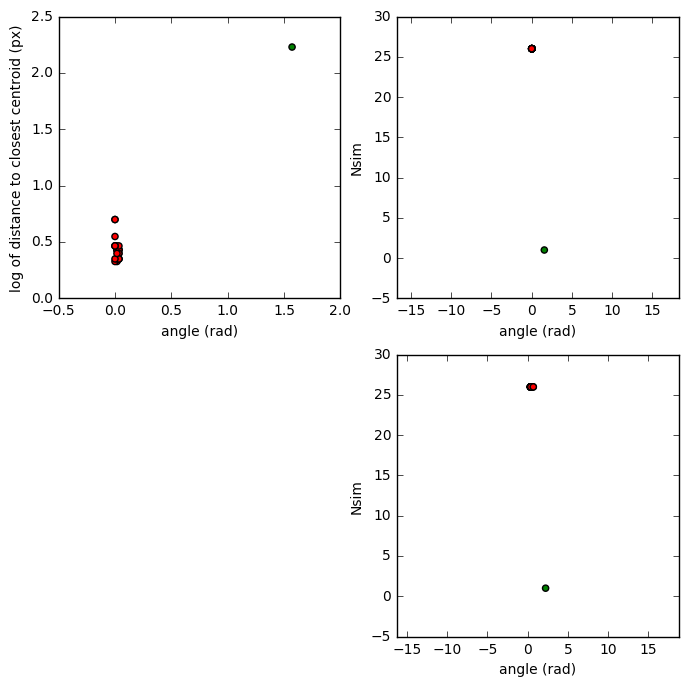

In [329]:
colors = ['g' if label else 'r' for label in labels_cl]

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.scatter(angles,np.log10(dist_clos),c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('log of distance to closest centroid (px)')
plt.axis('equal')

plt.subplot(222)
plt.scatter(angles,Nsim,c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('Nsim')
plt.axis('equal')

plt.subplot(224)
plt.scatter(np.log10(dist_clos),Nsim,c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('Nsim')
plt.axis('equal')


plt.show()

In [330]:
labels_cl

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

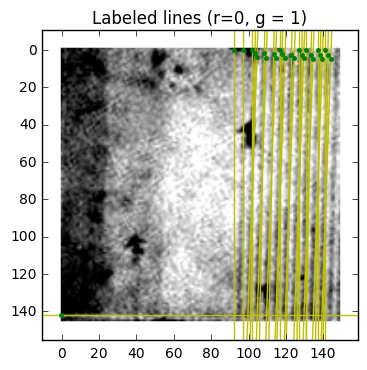

In [354]:
# plt.figure(figsize=(8,8))
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Labeled lines (r=0, g = 1)')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
# plot_lines_lab(lines_thr,labels_cl)
plot_lines(lines_thr)
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)
plt.plot(XC,YC,'.g')

plt.show()

In [332]:
# Pick correct group and analyze

# # Get dominant angle from top 5% of angles of line segments

# angle_dominant = 90 - np.percentile(thetas_pr,95)  # subtract 90 because thetas_pr were computed using atan2()
# angle_dominant = angle_dominant*np.pi/180

# idx_good = np.where(np.abs(angles - angle_dominant) < angle_res)[0]


In [333]:
# Choose based on Nsim (assumes majority are parralel and true)
idx_good = np.where(Nsim==np.max(Nsim))[0]

## Describe detected patterns

In [334]:
# Median angle in degrees
angle_good = np.median(angles[idx_good])*180/np.pi

In [335]:
# Calculate spacing between successive lines that are either horizontal or vertical
def get_spacing(lines,angles):
    XC, YC = get_centroids(lines)
    if (np.abs(np.mean(angles) - 0) <= 5*np.pi/180):
        spacing = np.diff(np.sort(XC))
    elif (np.abs(np.mean(angles) - np.pi/2) <= 5*np.pi/180):
        spacing = np.diff(np.sort(YC))
    else:
        print "lines are neither vertical or horizontal"
    
    return spacing

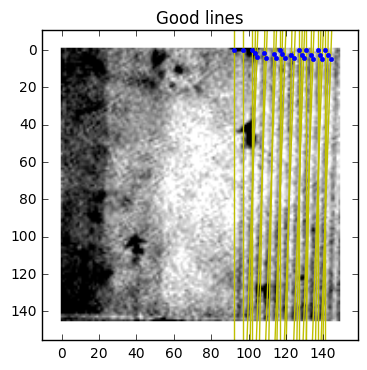

In [336]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Good lines')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr[idx_good])
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)
plt.plot(XC[idx_good],YC[idx_good],'.b')

plt.show()

In [337]:
spacing  = get_spacing(lines_thr[idx_good], angles[idx_good])

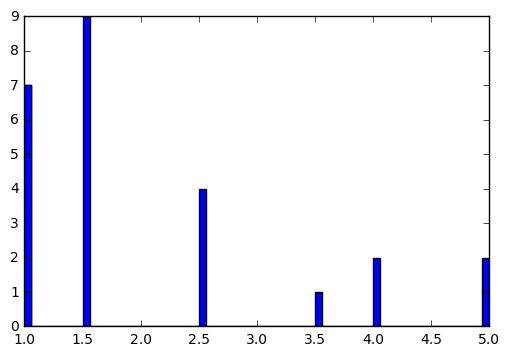

In [338]:
plt.hist(spacing,64)
plt.show()
# pick higher mode?

In [357]:
np.percentile(spacing,75)

2.5

In [355]:
# For now take average of top 75%
cycle = np.mean(spacing[spacing>np.percentile(spacing,75)])*5 # 5 meters per pixel


In [356]:
cycle

21.5

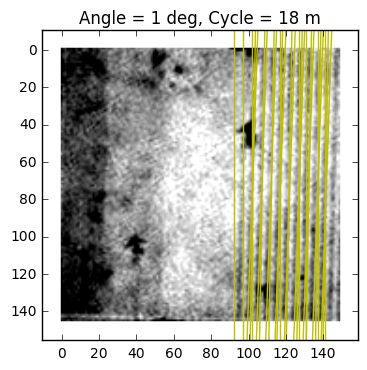

In [342]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Angle = %.0f deg, Cycle = %.0f m' % (np.round(angle_good),np.round(cycle)))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr[idx_good])
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)
# plt.plot(XC[idx_good],YC[idx_good],'.b')

plt.show()

In [343]:
# import scipy

In [344]:
# kernel = scipy.stats.gaussian_kde(spacing)

In [345]:
# Fit bimodal distribution??

# from scipy.optimize import curve_fit

# def gauss(x,mu,sigma,A):
#     return A*exp(-(x-mu)**2/2/sigma**2)

# def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
#     return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

# expected=(1,1,1,2,1,1)
# params,cov=curve_fit(bimodal,x,y,expected)
# sigma=sqrt(diag(cov))
# plot(x,bimodal(x,*params),color='red',lw=3,label='model')
# legend()
# print(params,'\n',sigma)

In [346]:
# # Decide to label according to clusters or lump all lines in the same label
# # if all lines have similar angles, then they belong to the same group, which is assumed to be in the true class
# lump = not(bool(np.sum(np.abs(np.diff(Nsim)))))
# lump

In [347]:
# if lump:
#     # spread in spacing 
#     spacing_true = get_spacing(lines_thr, angles)
#     avgspacing_true = np.mean(spacing_true)
#     spread_true  = iqr(spacing_true)
    
    
#     # number of lines in group as a fraction of total lines in image
#     frac_true = 1.
    
#     obs_vec_true = (spread_true,  frac_true,  1)

# else:
#     # Set true class (0 (red) or 1 (green))
#     true_class = 0

#     # Find lines belonging to each class
#     ix_true  = np.where(labels_cl==true_class)
#     ix_false = np.where(labels_cl!=true_class)

#     # average spacing between lines
#     spacing_true  = get_spacing(lines_thr[ix_true], angles[ix_true])
#     spacing_false = get_spacing(lines_thr[ix_false],angles[ix_false])
#     avgspacing_true = np.mean(spacing_true)
#     avgspacing_false = np.mean(spacing_false)    
    
#     # spread in spacing 
#     spread_true = iqr(spacing_true)
#     spread_false = iqr(spacing_false)
    
    

#     # number of lines in group as a fraction of total lines in image
#     frac_true  = len(ix_true[0])/float(len(ix_true[0])+len(ix_false[0]))
#     frac_false = 1 - frac_true
    
#     obs_vec_true  = (spread_true,  frac_true,  1)
#     obs_vec_false = (spread_false, frac_false, 0)


In [348]:
# # Don't output either class if it has only one member
# Ntrue = len(labels_cl[labels_cl==true_class])
# Nfalse = len(labels_cl[labels_cl==int(not(true_class))])
# Ntrue, Nfalse

In [349]:
# print obs_vec_true
# if not(lump):
#     print obs_vec_false

In [350]:
# TODO: Print vectors to file if there are more than one members in the cluster